#Beautiful Soup By Example

##Example 1 
Scrape a particular url on the US Government Archives website to get electoral college allocations by state.


In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

url = 'https://www.archives.gov/electoral-college/allocation'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
tables = soup.findAll('table')
#print(tables)

stateVoteList = []
for table in tables:
  p = ''
  p = table.findAll('p')
  for elem in p:
    #print(elem.text.split(' - ')[0], elem.text.split(' - ')[1])
    stateVoteList.append([elem.text.split(' - ')[0], elem.text.split(' - ')[1]])

df = pd.DataFrame(stateVoteList, columns = ['state', 'votes'])

print(df)

                   state     votes
0                Alabama   9 votes
1               Kentucky   8 votes
2           North Dakota   3 votes
3                 Alaska   3 votes
4              Louisiana   8 votes
5                   Ohio  18 votes
6                Arizona  11 votes
7                  Maine   4 votes
8               Oklahoma   7 votes
9               Arkansas   6 votes
10              Maryland  10 votes
11                Oregon   7 votes
12            California  55 votes
13         Massachusetts  11 votes
14          Pennsylvania  20 votes
15              Colorado   9 votes
16              Michigan  16 votes
17          Rhode Island   4 votes
18           Connecticut   7 votes
19             Minnesota  10 votes
20        South Carolina   9 votes
21              Delaware   3 votes
22           Mississippi   6 votes
23          South Dakota   3 votes
24  District of Columbia   3 votes
25              Missouri  10 votes
26             Tennessee  11 votes
27               Flo

##Example 2 
The Scenario is that we would like to scrape the Federal Reserve Open Market Committee (FOMC) Meeting minutes and view the length of the meeting minutes over time.

Step 1: We'll collect all the links for minutes from the Federal Reserve website. Using a starting point of 1996. Meeting minutes from prior to 2015 are in a different place to the more recent years. The FED seem to change the format of their minutes urls every few years, hence the extra if statement for 2007 through 2014. At the end of this block of code we've collected two lists. One is the link to minutes and the other is the meeting dates.

In [ ]:
import pandas as pd
import numpy as np
import re
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime

calendar_url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
recent_socket = urlopen(calendar_url)
recent_soup = BeautifulSoup(recent_socket, 'html.parser')

minutes = recent_soup.find_all('a', href=re.compile('^/monetarypolicy/fomcminutes\d{8}.htm'))
master_links = [minute.attrs['href'] for minute in minutes] 

for year in range(2014, 1995, -1):
    year_url = "https://www.federalreserve.gov/monetarypolicy/fomchistorical%d.htm" % (year)
    year_socket = urlopen(year_url)
    year_soup = BeautifulSoup(year_socket, 'html.parser')
    if year > 2007:
        year_minutes = year_soup.find_all('a', href=re.compile('^/monetarypolicy/fomcminutes\d{8}.htm'))
    else:
        year_minutes = year_soup.find_all('a', href=re.compile('^/fomc/minutes/\d{8}.htm'))
    year_links = [year_minute.attrs['href'] for year_minute in year_minutes]
    master_links.extend(year_links)

temp_list = [re.match('(.*?).htm', x).group(1) for x in master_links]
date_list = [temp[-8:] for temp in temp_list]


Step 2: Now we can loop through the list called master_links and scrape the minutes from each of these pages. We also create a more usable date format and some other derived columns and put them into a pandas dataframe.

In [ ]:
df = pd.DataFrame(columns=['pydate', 'date', 'year', 'month', 'day', 'text', 'minute_length', 'retrieved_url'])

for i in range(len(master_links) - 1, 0, -1):
  url = 'https://www.federalreserve.gov' + master_links[i]
  res = requests.get(url)
  html_page = res.content
  soup = BeautifulSoup(html_page, 'html.parser')
  for script in soup(['script', 'style']):
    script.extract()
  text = soup.get_text()
  lines = (line.strip() for line in text.splitlines())
  blocks = (phrase.strip() for line in lines for phrase in line.split("  "))
  # we're removing blank lines and in the next line we'll remove all line breaks
  text = '\n'.join(block for block in blocks if block)
  line = text.replace('\n', ' ')
  df.loc[len(df)] = [datetime.datetime(int(date_list[i][:4]), int(date_list[i][4:6]), int(date_list[i][-2:])), date_list[i], int(date_list[i][:4]), int(date_list[i][5:6]), int(date_list[i][7:8]), line, len(line), url]

print(df.head())

      pydate  ...                                      retrieved_url
0 1996-12-17  ...  https://www.federalreserve.gov/fomc/minutes/19...
1 1996-11-13  ...  https://www.federalreserve.gov/fomc/minutes/19...
2 1996-09-24  ...  https://www.federalreserve.gov/fomc/minutes/19...
3 1996-08-20  ...  https://www.federalreserve.gov/fomc/minutes/19...
4 1996-07-02  ...  https://www.federalreserve.gov/fomc/minutes/19...

[5 rows x 8 columns]


Step 3: Now let's have a look at what might be a first step in EDA (Exploratory Data Analysis). In this case we're looking at the length of the FOMC minutes over time.

Length of text in FOMC Minutes (1995-present)


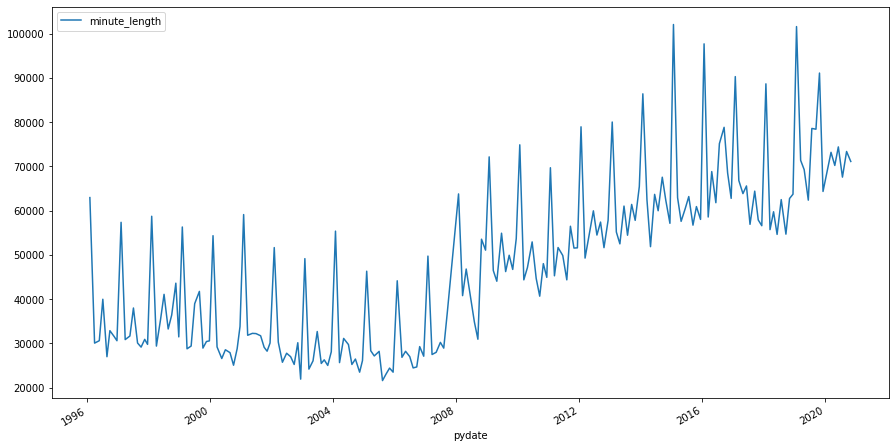

In [ ]:
import matplotlib.pyplot as plt

print("Length of text in FOMC Minutes (1995-present)")

plt.figure(figsize=(15,8))
ax = plt.gca()

df.plot(kind='line', x='pydate', y='minute_length', ax=ax)

plt.show()